# CESM Data Analysis  
Average to annual, compute z-scores from there 

### Import packages and file locations

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy, os, sys 
import cartopy.crs as ccrs 
import time as pytime
import datetime as dt

sys.path.insert(1, r'C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo')

import env_methods as em 

In [2]:
directory = r'D:\RIVERS_new'

### Import data and parameters (lat, lon, time)

In [4]:
start_time = pytime.time()

os.chdir(directory)

P=np.load('PRECT_LME_USA_ENSMEAN_850-1850.npy') # precip m/s
T=np.load('TREFHT_LME_USA_ENSMEAN_850-1850.npy') # temp K
EVAP=np.load('QSOIL_USA_LME_ENSMEAN_850-1850.npy') # evaporation mm/s
SNOWHLND=np.load('SNOWHLND_LME_USA_ENSMEAN_850-1850.npy') # ? 
SOILLIQ=np.load('SOILLIQ_USA_LME_ENSMEAN_850-1850.npy') # soil liquid water kg/m2
QCHANR=np.load('QCHANR_USA_LME_ENSMEAN_850-1850.npy') # river flow m3/s
SOILICE=np.load('SOILICE_USA_LME_ENSMEAN_850-1850.npy') # soil ice kg/m2
QRUNOFF = np.load('QRUNOFF_LME_USA_ENSMEAN_850-1850.npy') #total liquid runoff mm/s
QSNOMELT = np.load('QSNOMELT_LME_USA_ENSMEAN_850-1850.npy') #snow melt, mm/s

var = {'P':P, 
      'T':T,
      'EVAP':EVAP,
      'SNOWHLND':SNOWHLND,
      'SOILLIQ':SOILLIQ,
      'QCHANR':QCHANR,
      'SOILICE':SOILICE,
      'QSNOMELT':QSNOMELT,
      'QRUNOFF':QRUNOFF}
print('Loading variables = ' + str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')

var_def = {'P':'Precipitation', 
      'T':'Temperature',
      'EVAP':'Evaporation',
      'SNOWHLND':'Water equivalent snow depth',
      'SOILLIQ':'Soil Liquid Water',
      'QCHANR':'River Flow',
      'SOILICE':'Soil Ice',
      'QRUNOFF':'Total liquid runoff',
      'QSNOMELT':'Snow melt'
          }

Loading variables = 14.95651 seconds elapsed


In [5]:
start_time = pytime.time()
lats=np.load('NA_ATM_LME_lats.npy')
lons=np.load('NA_ATM_LME_lons.npy')

q_lats=np.load('CESM_LME_USA_lats.npy')
q_lons=np.load('CESM_LME_USA_lons.npy')
print('Loading parameters = ' + str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')

Loading parameters = 0.23363 seconds elapsed


In [6]:
time = []
for i in range(850,1850):
    for j in range(1,13):
        time.append(dt.datetime(i, j, 1))

### Compress to mean annual values from mean monthly values 

In [7]:
start_time = pytime.time()
var_ann = {}
var_mean = {}
for v in var:
    for i in np.arange(0,12000, 12):
        subset = var[v][i:i+12,:,:]
        subset = np.mean(subset, axis = 0)
        subset = np.expand_dims(subset, 0)
        if i == 0:
            var_new = subset
        else:
            var_new = np.concatenate((var_new, subset), axis = 0)
    var_ann[v] = var_new
    var_mean[v] = np.mean(var_new, axis = 0)
print('Compressing to annual = ' +str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')


Compressing to annual = 45.37002 seconds elapsed


### Standardize - convert to z-scores 
Compute z-scores by 
$$ z = \dfrac{x - \mu} {\sigma} $$  

x = a single annual measurement  
$\mu$ = average value for all measurments within the 850-1850AD range  
$ \sigma $ = standard deviation for all measurments within the 850-1850AD range  

In [8]:
start_time = pytime.time()
s_var = {}
for v in var:
    temp = var_ann[v].copy()
    stdev = np.std(temp, axis = 0)
    mean = np.mean(temp, axis = 0)
    for i in range(temp.shape[0]):
        frame = temp[i, :, :]
        normed = np.divide(np.subtract(frame, mean), stdev)
        temp[i, :, :] = normed 
    s_var[v] = temp 
    
print('Normalizing data = ' + str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')

C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Normalizing data = 0.3178 seconds elapsed


### Subset data
Medieval Climate Anomaly (MCA, 1000-1200AD) and Little Ice Age (LIA, 1600-1800AD)

In [9]:
lcm_var = {} #average of all values in the LCM: 1600-1800
mca_var = {} #average of all values in the MCA: 1000-1200

years = np.arange(850, 1850)
lcm_ind = [em.find_closest_val(1600, years), em.find_closest_val(1800, years)]
mca_ind = [em.find_closest_val(1000, years), em.find_closest_val(1200, years)]

for v in s_var:
    lcm_var[v] = np.mean(s_var[v][lcm_ind[0]:lcm_ind[1]], axis = 0)
    mca_var[v] = np.mean(s_var[v][mca_ind[0]:mca_ind[1]], axis = 0)


### Plot
Generate plots of all standardized variables, averaged in both MCA and LIA

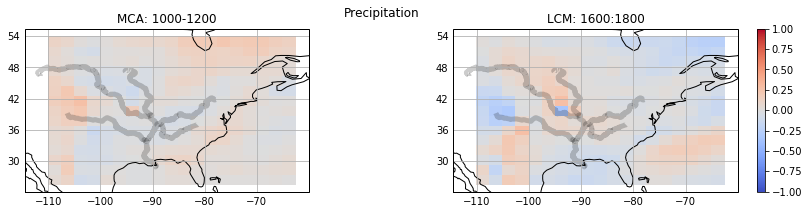

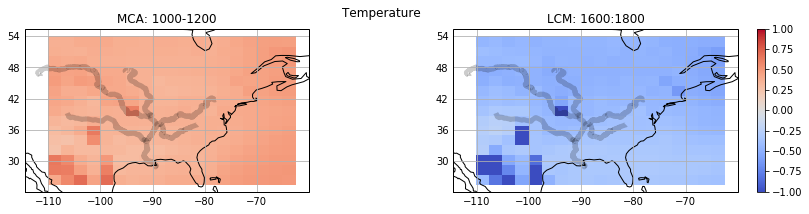

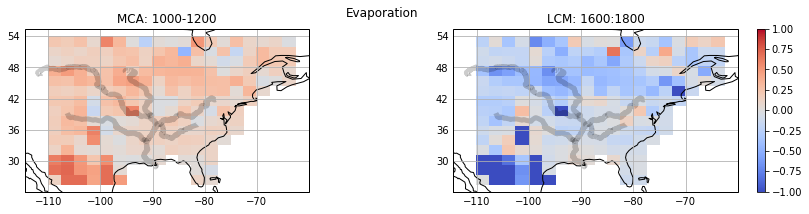

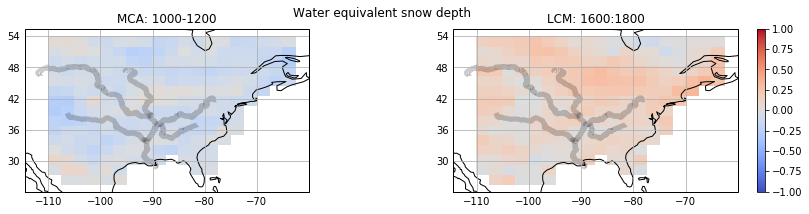

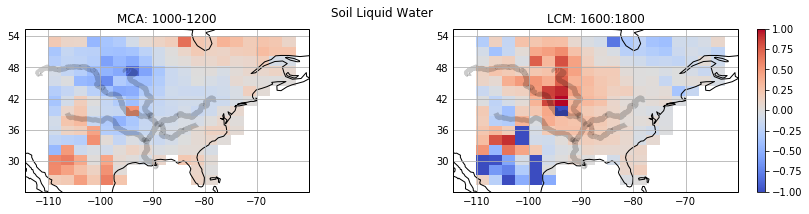

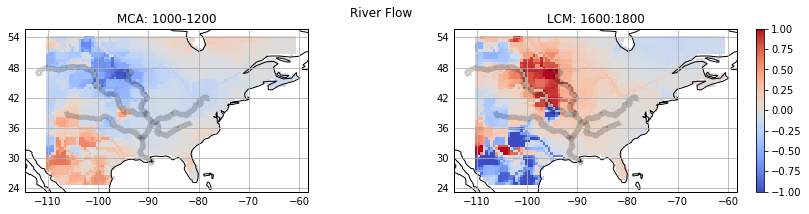

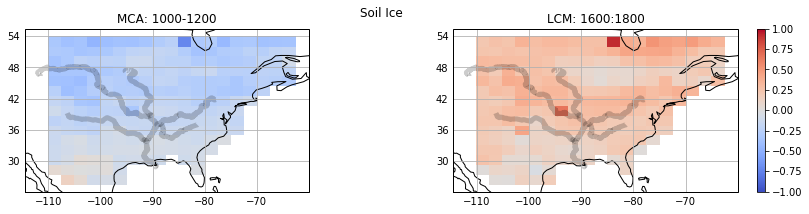

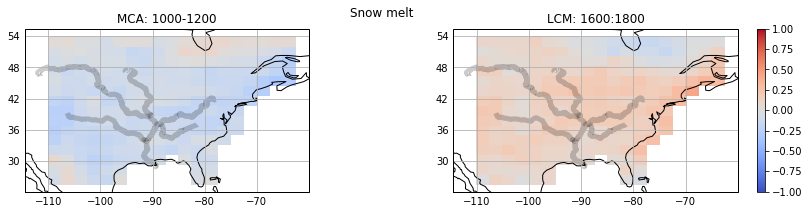

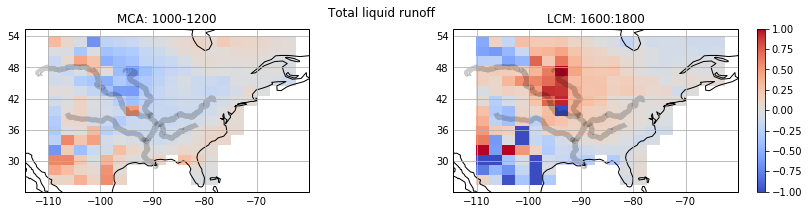

In [10]:
import geopandas as gpd 

path1 = r'D:\Shapefiles\msrivs\msrivs.shp'
shp1 = gpd.read_file(path1)

vmin = -1
vmax = 1
for v in lcm_var:
    use_lons = lons
    use_lats = lats
    if v == 'QCHANR':
        use_lons = q_lons
        use_lats = q_lats
    plt.figure(figsize = (15, 3))

    plt.suptitle(var_def[v])

    for i in range(2):
        ax = plt.subplot(1, 2, i + 1, projection = ccrs.PlateCarree())
        ax.coastlines()

        if i == 0:
            mesh = plt.pcolormesh(use_lons, use_lats, mca_var[v],cmap = 'coolwarm', vmin = vmin, vmax = vmax)
            plt.title('MCA: 1000-1200')
        else:
            mesh = plt.pcolormesh(use_lons, use_lats, lcm_var[v], cmap = 'coolwarm', vmin = vmin, vmax = vmax)
            plt.title('LCM: 1600:1800')
            plt.colorbar(mesh)
        gl = ax.gridlines(draw_labels = True)
        gl.xlabels_top = False
        gl.ylabels_right = False

        plt.xlabel('lon')
        plt.ylabel('lat')

        shp1.plot(ax=ax, edgecolor='black', linewidth = 5, alpha = 0.2)
        

### Exploring the effects of seasonality 
Here we explore the effects of seasonality on river discharge and precipitation. Seasons are defined as:   
Winter = DJF  
Spring = MAM  
Summer = JJA  
Fall = SON   

### Subset data into seasons and into time periods of interest (MCA and LIA)

In [11]:
seasons_def = {'winter':[12, 1, 2],
              'spring':[3,4,5],
              'summer':[6,7,8],
              'fall':[9,10,11]}

In [12]:
indices = {}
indices['mca'] = {}
indices['lcm'] = {}
winter = []
winter_time = []
for s in seasons_def:
    temp_mca = []
    temp_lcm = []
    
    for i in range(len(time)):
        if time[i].month in seasons_def[s]:
            
            if time[i].year in range(1000, 1200):
                temp_mca.append(i)
            
            if time[i].year in range(1600, 1800):
                temp_lcm.append(i)
                
            if s == 'winter':
                winter.append(i)
                winter_time.append(time[i])
                
    indices['mca'][s] = temp_mca
    indices['lcm'][s] = temp_lcm 

In [13]:
len(winter)

3000

In [14]:
seasons = {}
seasons['mca'] = {}
seasons['lcm'] = {}
for t in indices.keys():
    for s in seasons_def:
        seasons[t][s] = {}
        for v in var:
            if v == 'P' or v == 'QCHANR' or v =='SNOWHLND':
                data = var[v][indices[t][s], :, :]
                data[data == 9.999999616903162e+35] = np.nan
                seasons[t][s][v] = data

### Plot discharge and precipitation by season in LIA and MCA 
__Note: colormap is standardized so figures are comparable__

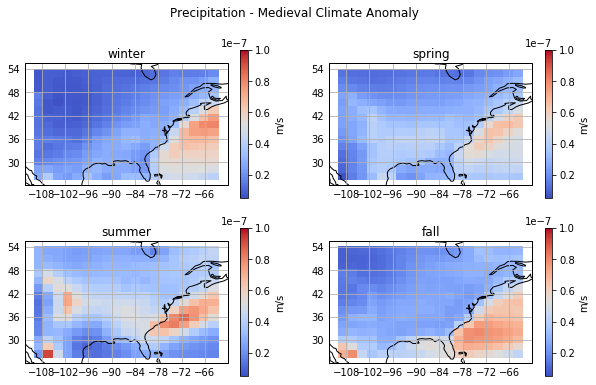

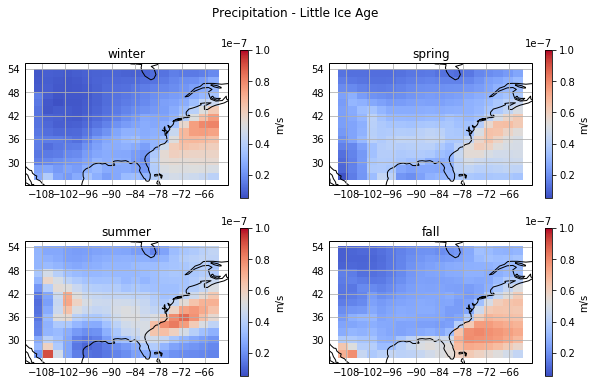

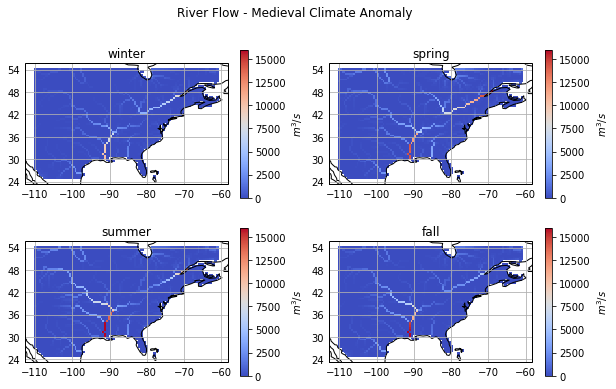

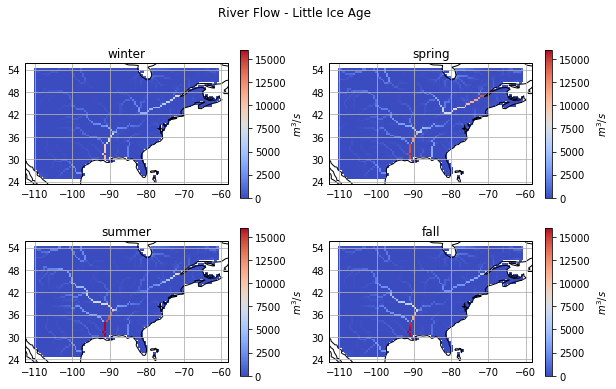

In [15]:
for k in ['P', 'QCHANR']:
    
    for i in seasons.keys(): #iterate mca/lcm 
        fig = plt.figure(figsize = (10, 6))
        if i == 'mca':
            plt.suptitle(var_def[k] + ' - Medieval Climate Anomaly')
        else:
            plt.suptitle(var_def[k] + ' - Little Ice Age')
        counter = 1
    
        for j in seasons[i].keys(): #iterate seaosons
            ax = plt.subplot(2, 2, counter, projection = ccrs.PlateCarree())
            
            ax.coastlines()
            gl = ax.gridlines(draw_labels = True)
            gl.xlabels_top = False
            gl.ylabels_right = False
            counter += 1 
            use_lats = lats
            use_lons = lons
            
            vmin = 0.5*10**-8
            vmax = 10*10**-8
            if k == 'QCHANR':
                use_lats = q_lats
                use_lons = q_lons
                vmin = 0
                vmax = 16000
            
            mesh = plt.pcolormesh(use_lons, use_lats, np.mean(seasons[i][j][k], axis = 0), cmap = 'coolwarm', vmin = vmin, vmax = vmax)
            cb = plt.colorbar(mesh)
            if k == 'P':
                cb.set_label('m/s')
            else:
                cb.set_label('$m^3/s$')
            
            plt.title(j)


### Take the difference of discharge and precipitation between the MCA and LIA 
__Note: colormap is standardized so figures are comparable__  
Blue = LIA has higher value than MCA  
Red = LIA has lower value than MCA  

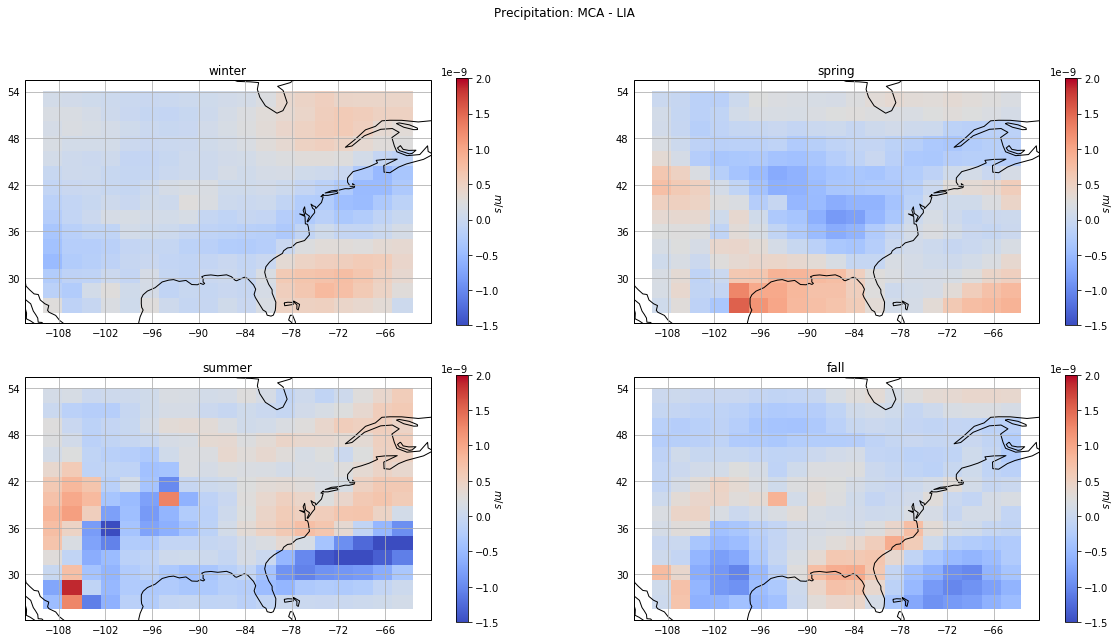

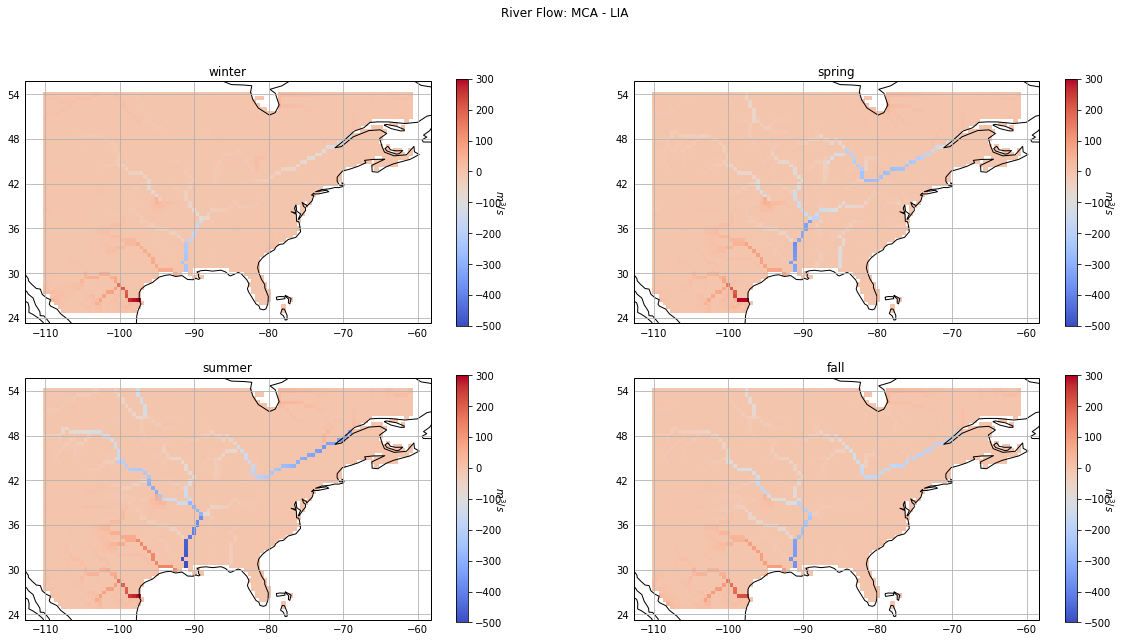

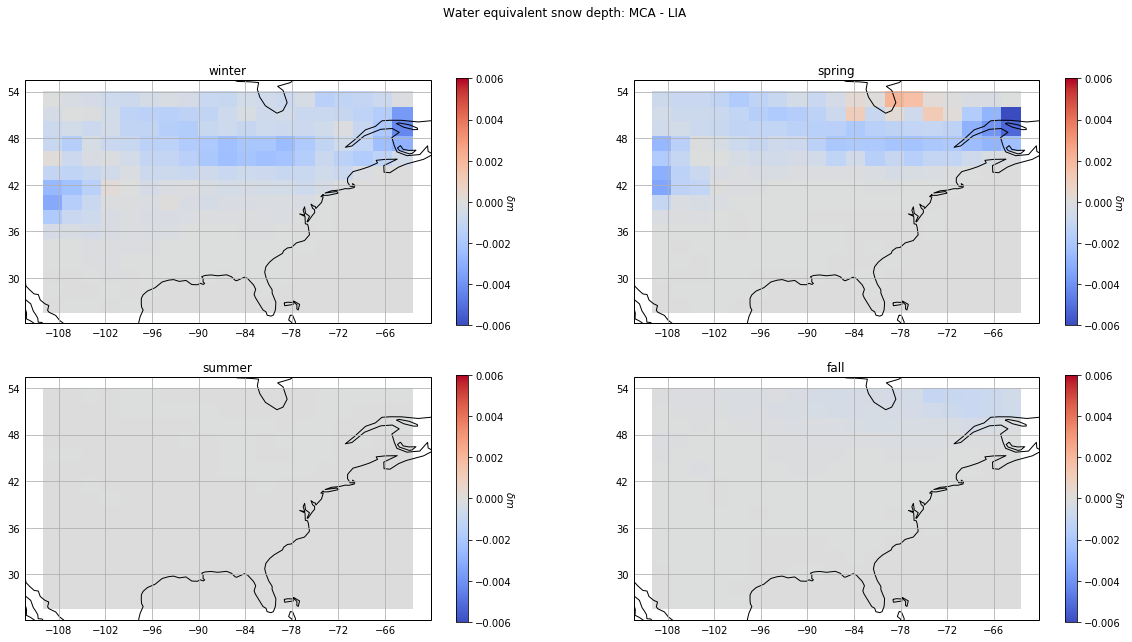

In [16]:
for k in ['P', 'QCHANR', 'SNOWHLND']:
    fig = plt.figure(figsize = (20, 10))
    counter = 1
    plt.suptitle(var_def[k] + ': MCA - LIA')
    for j in seasons['mca'].keys(): #iterate seasons
        ax = plt.subplot(2, 2, counter, projection = ccrs.PlateCarree())
        counter += 1 
        
        ax.coastlines()
        gl = ax.gridlines(draw_labels = True)
        gl.xlabels_top = False
        gl.ylabels_right = False
        use_lats = lats
        use_lons = lons
        vmin = -1.5*10**-9
        vmax = 2*10**-9
        cbar_label = '$m/s$'
        if k == 'QCHANR':
            use_lats = q_lats
            use_lons = q_lons
            vmin = -500
            vmax = 300
            cbar_label = '$m^3/s$'
        if k == 'SNOWHLND':
            vmin = -0.006
            vmax = 0.006
            cbar_label ='$\delta m$'
        data = np.mean(seasons['mca'][j][k], axis = 0) - np.mean(seasons['lcm'][j][k], axis = 0)
        mesh = plt.pcolormesh(use_lons, use_lats, data, cmap = 'coolwarm', vmin = vmin, vmax = vmax)
        cb = plt.colorbar(mesh)
        cb.set_label(cbar_label, rotation = 270)
        plt.title(j)


### Snowpack Analysis (reanalysis, haha) 
Raw values, averaged for winter 

2. fix snow depth as only winter  
	be more careful with  
	look at raw values, not standardized  
	plot "average for the winter"  
	rough sense of how much accumulated snow there is  


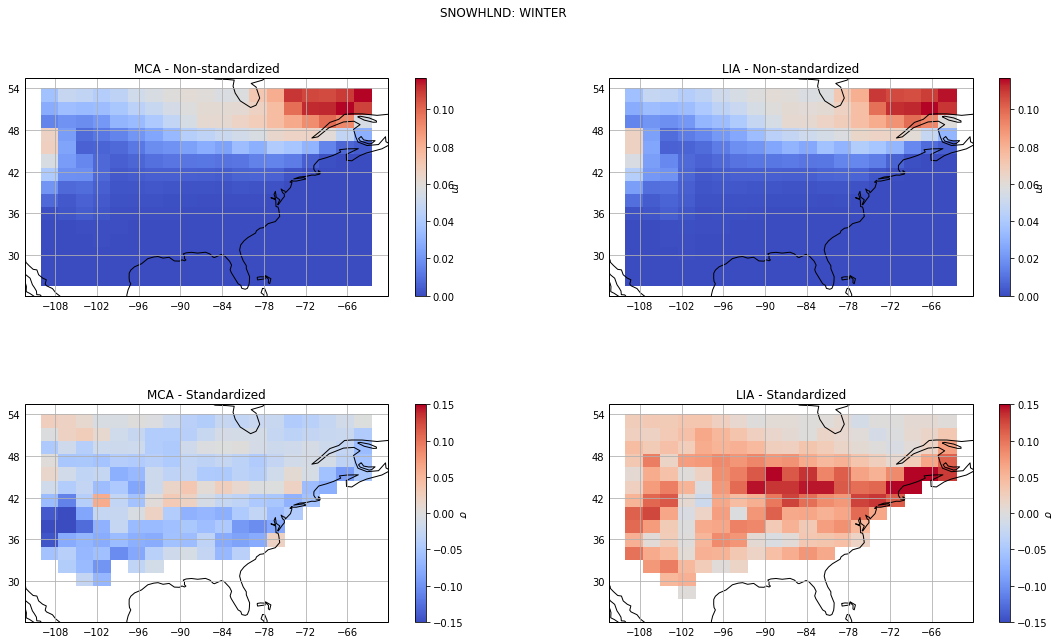

In [17]:
plt.figure(figsize = (20, 10))
plt.suptitle('SNOWHLND: WINTER')

ax = plt.subplot(2,2,1, projection = ccrs.PlateCarree())
plt.title('MCA - Non-standardized')
mesh = plt.pcolormesh(lons, lats, np.mean(seasons['mca']['winter']['SNOWHLND'], axis = 0), cmap = 'coolwarm')
cb = plt.colorbar(mesh)
cb.set_label('$m$', rotation = 270)
ax.coastlines()
gl = ax.gridlines(draw_labels = True)
gl.xlabels_top = False
gl.ylabels_right = False


ax = plt.subplot(2,2,2, projection = ccrs.PlateCarree())
plt.title('LIA - Non-standardized')
plt.pcolormesh(lons, lats, np.mean(seasons['lcm']['winter']['SNOWHLND'], axis = 0),cmap = 'coolwarm')
cb = plt.colorbar(mesh)
cb.set_label('$m$', rotation = 270)
ax.coastlines()
gl = ax.gridlines(draw_labels = True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.subplots_adjust(hspace=0.5, wspace = 0.1)
#standardize winter
snow_winter = var['SNOWHLND'][winter, :, :]

mean = np.mean(var['SNOWHLND'][winter, :, :], axis = 0)
stdev = np.std(var['SNOWHLND'][winter, :, :], axis = 0)

for i in range(snow_winter.shape[0]):
    frame = snow_winter[i, :, :]
    frame[frame == 0] = np.nan
    s_frame = (frame - mean) / stdev
    snow_winter[i, :, :] = s_frame

wt_mca = []
wt_lcm = []
for i in range(len(winter_time)):
    if winter_time[i].year in range(1000,1200):
        wt_mca.append(i)
    if winter_time[i].year in range(1600,1800):
        wt_lcm.append(i)


#plot
ax = plt.subplot(2,2,3, projection = ccrs.PlateCarree())
plt.title('MCA - Standardized')
mesh = plt.pcolormesh(lons, lats, np.mean(snow_winter[wt_mca, :, :], axis = 0), cmap = 'coolwarm', vmin = -0.15, vmax = 0.15)
cb = plt.colorbar(mesh)
cb.set_label('$\sigma$', rotation = 270)
ax.coastlines()
gl = ax.gridlines(draw_labels = True)
gl.xlabels_top = False
gl.ylabels_right = False

ax = plt.subplot(2,2,4, projection = ccrs.PlateCarree())
plt.title('LIA - Standardized')
mesh = plt.pcolormesh(lons, lats, np.mean(snow_winter[wt_lcm, :, :], axis = 0), cmap = 'coolwarm',vmin = -0.15, vmax = 0.15)
cb = plt.colorbar(mesh)
cb.set_label('$\sigma$', rotation = 270)
ax.coastlines()
gl = ax.gridlines(draw_labels = True)
gl.xlabels_top = False
gl.ylabels_right = False

plt.subplots_adjust(hspace=0.5, wspace = 0.1)



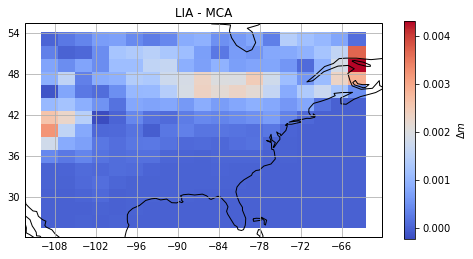

In [18]:
plt.figure(figsize = (8, 4))
ax = plt.subplot(projection = ccrs.PlateCarree())
mesh = plt.pcolormesh(lons, lats, 
               np.subtract(np.mean(seasons['lcm']['winter']['SNOWHLND'], axis = 0), np.mean(seasons['mca']['winter']['SNOWHLND'], axis = 0))
               ,cmap = 'coolwarm')
cb = plt.colorbar(mesh)
ax.coastlines()
gl = ax.gridlines(draw_labels = True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('LIA - MCA')
cb.set_label('$\Delta m$')

### Standardized Precipitation Seasonality 
1. add seasonal precip to z-scores   
	probably not that different 
    


In [19]:
seasonal_p_ind = {}

for s in seasons_def:
    index = []
    for i in range(len(time)):
        if time[i].month in seasons_def[s]:
            index.append(i)
    seasonal_p_ind[s] = index

means = {}
stdevs = {}
for s in seasons_def:
    means[s] = np.mean(var['P'][seasonal_p_ind[s], :, :], axis = 0)
    stdevs[s] = np.std(var['P'][seasonal_p_ind[s], :, :], axis = 0)
    
    
P_stand = {}

for s in seasons_def: 
    data = var['P'][seasonal_p_ind[s], :, :]
    for j in range(data.shape[0]):
        frame = data[j, :, :]
        frame = (frame - means[s]) / stdevs[s]
        data[j, :, :] = frame
    
    P_stand[s] = data




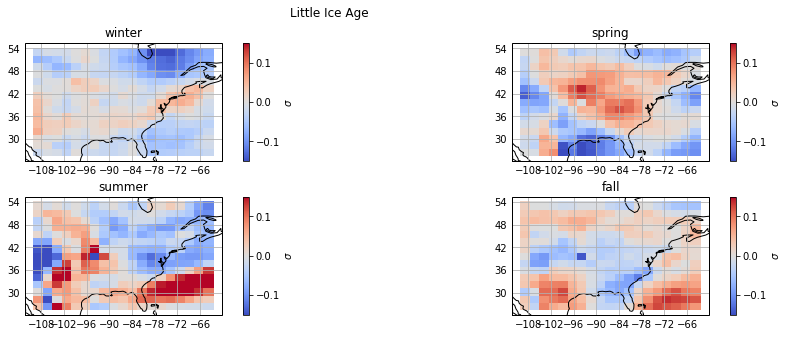

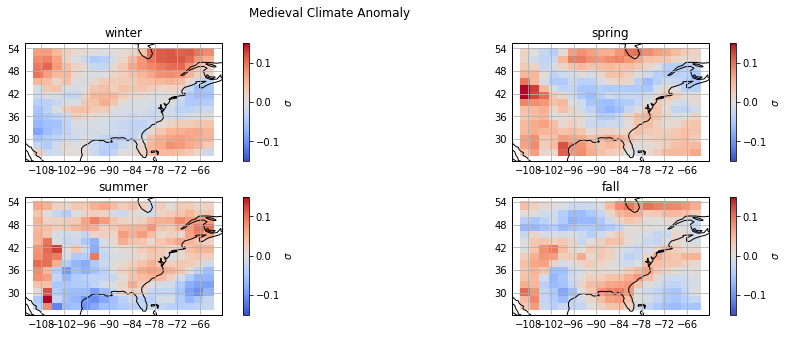

In [20]:
normed_precip = em.normalize_data(var['P'], time)
mca_np = {}
lia_np = {}
for s in seasons_def:
    temp1 = []
    temp2 = []
    
    for i in range(len(time)):
        if time[i].month in seasons_def[s]:
            if time[i].year in range(1000,1200):
                temp1.append(i)
            if time[i].year in range(1600, 1800):
                temp2.append(i)
    lia_np[s] = temp2
    mca_np[s] = temp1

t_Counter = 0 
for x in [lia_np, mca_np]:
    plt.figure(figsize = (16, 5))
    if t_Counter == 0: plt.suptitle('Little Ice Age')
    else: plt.suptitle('Medieval Climate Anomaly')
    t_Counter += 1
    counter = 1
    for s in seasons_def:
        ax = plt.subplot(2,2,counter, projection = ccrs.PlateCarree())
        plt.title(s)
        counter = counter + 1
        ax.coastlines()
        data = np.mean(normed_precip[x[s],:, :], axis = 0)
        mesh = plt.pcolormesh(lons, lats, data, cmap ='coolwarm', vmin = -0.15, vmax = 0.15)
        cb = plt.colorbar(mesh)
        cb.set_label('$\sigma$')
        gl = ax.gridlines(draw_labels = True)
        gl.xlabels_top = False
        gl.ylabels_right = False
    plt.subplots_adjust(hspace=0.3)